## Load data

In [8]:
import pandas as pd
import ast
import numpy as np

# Load in data
admissions = 'tedsa_puf_2019.csv'
df_raw = pd.read_csv(f'../../Downloads/{admissions}')

## Filter out select rows and columns

In [9]:
# Get count of original number of rows
old_rows = len(df_raw)

# Drop defined columns (year of admission, case id, geographic metro area, geographic division, geographic region)
columns_to_drop = ['ADMYR', 'CASEID', 'CBSA2010', 'DIVISION', 'REGION']
df = df_raw.drop(columns=columns_to_drop)
print(f'Dropped {len(columns_to_drop)} columns ({len(df.columns)} remain)')

# Drop values where dependent variable is unknown
df = df[df['METHUSE'] != -9]

# Only keep patients admitted with self-described use of an opioid as their primary substance use (i.e., SUB1 = 5, 6, or 7)
df = df[df['SUB1'].between(5, 7)]
new_rows = len(df)
percent_change = round(100*(old_rows-new_rows)/old_rows, 1)
print(f'Dropped {"{:,}".format(old_rows-new_rows)} observations or {percent_change}% of the data ({"{:,}".format(new_rows)} rows remain)')

df = df.reset_index(drop='index')

Dropped 5 columns (57 remain)
Dropped 1,340,233 observations or 71.9% of the data (524,134 rows remain)


## Balance dataset

In [11]:
# Split into two dataframes, printing result
df_ones = df[df['METHUSE']==1]
df_twos = df[df['METHUSE']==2]
print('Classes before down-sampling:', len(df_ones), len(df_twos))

# Sample down df_twos to the length of df_ones, printing result
ratio = len(df_ones)/len(df_twos)
df_twos = df_twos.sample(frac=ratio)
print('Classes after down-sampling:', len(df_ones), len(df_twos))

# Recombine and shuffle for good measure
df = pd.concat([df_ones, df_twos], axis=0)
df = df.sample(frac=1).reset_index(drop=True)

Classes before down-sampling: 211743 312391
Classes after down-sampling: 211743 211743


## Make dataset human-readable

In [13]:
# Load in variable dictionary
with open('VariableDictionary.txt') as file:
    variable_dict_string = file.read()
    variable_dict = ast.literal_eval(variable_dict_string)

# Rename entries in column according to dictionary
df2 = df.copy()
for col, col_dict in variable_dict.items():
    if col in df2.columns:
        for old_value, new_value in variable_dict[col].items():
            df2[col] = df2[col].replace(old_value, new_value)

# Rename "-9" values as "Unknown"
for col in df2.columns:
    df2[col] = df2[col].replace(-9, 'Unknown')

# Merge DETNLF (detailed not in labor force) into EMPLOY==4 (not in labor force)
detailed_employ = []

for idx, value in df2.iterrows():
    if value['EMPLOY'] == 'NotInLaborForce':
        if value['DETNLF'] == 'Unknown':
            # Assign 'UnknownNotInLaborForce' if 'NotInLaborForce' and 'Unknown'
            detailed_employ.append('UnknownNotInLaborForce')
        else:
            # Otherwise, assign as the DETNLF value
            detailed_employ.append(value['DETNLF'])
    else:
        # Assign the EMPLOY value if not 'NotInLaborForce'
        detailed_employ.append(value['EMPLOY'])

# Add a new column for detailed employment and drop the two source columns
df2['DETEMPLOY'] = detailed_employ
df2 = df2.drop(columns=['EMPLOY', 'DETNLF'])

# Convert dependent variable to binary integer
df2['METHUSE'] = df2['METHUSE'].replace('MethUse', 1)
df2['METHUSE'] = df2['METHUSE'].replace('NoMethUse', 0)

# XGBoost and Shapley

### Make machine-readable dataset (encoding)

In [15]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from sklearn.preprocessing import OrdinalEncoder

df4 = df2.copy()
# df4 = df4.sample(frac=0.1)  # small size for testing code

df4['STFIPS'] = df4['STFIPS'].astype('category').cat.codes
df4['EDUC'] = OrdinalEncoder(categories=[['Unknown', 'Grade8OrLess', 'Grade9To11', 'Grade12OrGED', '1To3yCollege', '4yCollegePlus']]).fit_transform(df4[['EDUC']])
df4['MARSTAT'] = df4['MARSTAT'].astype('category').cat.codes
df4['SERVICES'] = df4['SERVICES'].astype('category').cat.codes
df4['DETCRIM'] = df4['DETCRIM'].astype('category').cat.codes
df4['NOPRIOR'] = OrdinalEncoder(categories=[['Unknown', '0PriorTreatments', '1PriorTreatments', '2PriorTreatments', '3PriorTreatments',
                                            '4PriorTreatments', '5PlusPriorTreatments']]).fit_transform(df4[['NOPRIOR']])
df4['PSOURCE'] = df4['PSOURCE'].astype('category').cat.codes
df4['ARRESTS'] = OrdinalEncoder(categories=[['Unknown', '0Arrest', '1Arrest', '2PlusArrest']]).fit_transform(df4[['ARRESTS']])
# df4['METHUSE'] = df4['METHUSE'].astype('category').cat.codes
df4['PSYPROB'] = df4['PSYPROB'].astype('category').cat.codes
df4['PREG'] = df4['PREG'].astype('category').cat.codes
df4['GENDER'] = df4['GENDER'].astype('category').cat.codes
df4['VET'] = df4['VET'].astype('category').cat.codes
df4['LIVARAG'] = df4['LIVARAG'].astype('category').cat.codes
df4['DAYWAIT'] = OrdinalEncoder(categories=[['Unknown', '0DaysWait', '1To7DaysWait', '8To14DaysWait', '15To30DaysWait',
                                            '31PlusDaysWait']]).fit_transform(df4[['DAYWAIT']])
df4['DSMCRIT'] = df4['DSMCRIT'].astype('category').cat.codes
df4['AGE'] = OrdinalEncoder(categories=[['Age12To14', 'Age15To17', 'Age18To20', 'Age21To24', 'Age25To29', 'Age30To34', 'Age35To39', 'Age40To44',
                                        'Age45To49', 'Age50To54', 'Age55To64', 'Age65Plus' ]]).fit_transform(df4[['AGE']])
df4['RACE'] = df4['RACE'].astype('category').cat.codes
df4['ETHNIC'] = df4['ETHNIC'].astype('category').cat.codes
df4['PRIMINC'] = df4['PRIMINC'].astype('category').cat.codes
df4['SUB1'] = df4['SUB1'].astype('category').cat.codes
df4['SUB2'] = df4['SUB2'].astype('category').cat.codes
df4['SUB3'] = df4['SUB3'].astype('category').cat.codes
df4['ROUTE1'] = df4['ROUTE1'].astype('category').cat.codes
df4['ROUTE2'] = df4['ROUTE2'].astype('category').cat.codes
df4['ROUTE3'] = df4['ROUTE3'].astype('category').cat.codes
df4['FREQ1'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ1']])
df4['FREQ2'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ2']])
df4['FREQ3'] = OrdinalEncoder(categories=[['Unknown', 'NoUsePastMonth', 'SomeUse', 'DailyUse']]).fit_transform(df4[['FREQ3']])
df4['FRSTUSE1'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE1']])
df4['FRSTUSE2'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE2']])
df4['FRSTUSE3'] = OrdinalEncoder(categories=[['Unknown', '11yLess', '12To14y', '15To17y', '18To20y', '21To24y', '25To29y',
                                             '30yPlus']]).fit_transform(df4[['FRSTUSE3']])
df4['HLTHINS'] = df4['HLTHINS'].astype('category').cat.codes
df4['PRIMPAY'] = df4['PRIMPAY'].astype('category').cat.codes
df4['FREQ_ATND_SELF_HELP'] = OrdinalEncoder(categories=[['Unknown', 'NoAttendance', 'SomeAttendance', '1To3TimesPastMonth', '4To7TimesPastMonth',
                                                        '8To30TimesPastMonth']]).fit_transform(df4[['FREQ_ATND_SELF_HELP']])
df4['ALCFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['ALCFLG']])
df4['COKEFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['COKEFLG']])
df4['MARFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['MARFLG']])
df4['HERFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['HERFLG']])
df4['METHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['METHFLG']])
df4['OPSYNFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OPSYNFLG']])
df4['PCPFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['PCPFLG']])
df4['HALLFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['HALLFLG']])
df4['MTHAMFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['MTHAMFLG']])
df4['AMPHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['AMPHFLG']])
df4['STIMFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['STIMFLG']])
df4['BENZFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['BENZFLG']])
df4['TRNQFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['TRNQFLG']])
df4['BARBFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['BARBFLG']])
df4['SEDHPFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['SEDHPFLG']])
df4['INHFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['INHFLG']])
df4['OTCFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OTCFLG']])
df4['OTHERFLG'] = OrdinalEncoder(categories=[['NotReported', 'Reported']]).fit_transform(df4[['OTHERFLG']])
# df4['DIVISION'] = df4['DIVISION'].astype('category').cat.codes
# df4['REGION'] = df4['REGION'].astype('category').cat.codes
df4['IDU'] = OrdinalEncoder(categories=[['NoIDU', 'IDU']]).fit_transform(df4[['IDU']])
df4['ALCDRUG'] = OrdinalEncoder(categories=[['OtherDrugs', 'AlcoholAndDrugs']]).fit_transform(df4[['ALCDRUG']])
df4['DETEMPLOY'] = df4['DETEMPLOY'].astype('category').cat.codes

In [17]:
# # Show the share of observations by state
# df2.groupby('STFIPS').count()/len(df2)

## Train XG Boost model

In [18]:
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X = df4.drop('METHUSE', axis=1)
y = df4['METHUSE'].astype('float')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)

In [19]:
import xgboost as xgb
from sklearn.metrics import accuracy_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

# Search the parameter grid
# Docs: https://xgboost.readthedocs.io/en/latest/parameter.html
# https://www.kaggle.com/code/prashant111/a-guide-on-xgboost-hyperparameters-tuning/notebook#2.-XGBoost-hyperparameters-
space={'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1, 0.01),
       'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
       'gamma': hp.quniform('gamma', 0.5, 1, 0.05),
       'learning_rate': hp.quniform('learning_rate', 0.01, 0.5, 0.01),
       'max_depth': hp.quniform("max_depth", 3, 27, 1),
       'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
       'n_estimators': hp.choice('n_estimators', range(100, 1000)),
       'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
       'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
       'subsample': hp.quniform('subsample', 0.5, 1, 0.05)
    }

def objective(space):
    clf=xgb.XGBClassifier(colsample_bytree=round(space['colsample_bytree'], 0),
                          early_stopping_rounds=10,
                          eta=space['eta'],
                          eval_metric='auc',
                          gamma=space['gamma'],
                          learning_rate=space['learning_rate'],
                          max_depth=int(round(space['max_depth'], 0)),
                          min_child_weight=space['min_child_weight'],
                          n_estimators=space['n_estimators'],
                          objective='binary:logistic',
                          reg_alpha=space['reg_alpha'],
                          reg_lambda=space['reg_lambda'],
                          seed=24,
                          subsample=round(space['subsample'], 0))

    evaluation = [( X_train, y_train), ( X_test, y_test)]

    clf.fit(X_train, y_train, eval_set=evaluation, verbose=False)

    pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, pred>0.5)
    print ("SCORE:", round(accuracy, 3))
    return {'loss': -accuracy, 'status': STATUS_OK }

In [21]:
# Begin training
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 50,          # <-- bring back to 50
                        trials = trials)

  0%|          | 0/50 [00:03<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [22]:
"""
# Best from 100 runs (50 would have done just fine)

{'colsample_bytree': 0.55,
 'eta': 0.15000000000000002,
 'gamma': 0.8,
 'learning_rate': 0.27,
 'max_depth': 20.0,
 'min_child_weight': 3.0,
 'n_estimators': 598,
 'reg_alpha': 40.0,
 'reg_lambda': 0.38166847419409755,
 'subsample': 0.6000000000000001}
"""

best_hyperparams = {'colsample_bytree': 0.55,
                     'eta': 0.15000000000000002,
                     'gamma': 0.8,
                     'learning_rate': 0.27,
                     'max_depth': 20.0,
                     'min_child_weight': 3.0,
                     'n_estimators': 598,
                     'reg_alpha': 40.0,
                     'reg_lambda': 0.38166847419409755,
                     'subsample': 0.6000000000000001}

best_hyperparams

{'colsample_bytree': 0.55,
 'eta': 0.15000000000000002,
 'gamma': 0.8,
 'learning_rate': 0.27,
 'max_depth': 20.0,
 'min_child_weight': 3.0,
 'n_estimators': 598,
 'reg_alpha': 40.0,
 'reg_lambda': 0.38166847419409755,
 'subsample': 0.6000000000000001}

In [21]:
# import xgboost as xgb
# import shap
# import numpy as np
#
# # Train XGBoost model
# model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, seed=24)
# model.fit(X_train, y_train)

In [23]:
# stop

### Interpretability

In [24]:
import shap
import numpy as np

best_hyperparams_formatted = best_hyperparams.copy()
best_hyperparams_formatted['max_depth'] = int(best_hyperparams['max_depth'])
best_hyperparams_formatted['eval_metric'] = 'auc'
best_hyperparams_formatted['objective'] = 'binary:logistic'
best_hyperparams_formatted['seed'] = 24

best_model = xgb.XGBClassifier(**best_hyperparams_formatted)
best_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.55, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.15000000000000002,
              eval_metric='auc', feature_types=None, gamma=0.8,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.27, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=3.0, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=598, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
# from sklearn.metrics import accuracy_score
#
# # Assuming you have already trained the model and made predictions as shown in the previous example
# # y_pred contains the predicted class labels (0 or 1) or probabilities
#
# # Convert predicted probabilities to class labels (0 or 1)
# y_pred = best_model.predict(X_test)
# y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]
#
# # Calculate accuracy
# accuracy = accuracy_score(y_test, y_pred_binary)
# print(f'Accuracy on the testing data: {accuracy}')

In [28]:
# Generate Shapley values
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test) # change to X_test

[20:55:08] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [29]:
shap_values   # Can we export these values as a csv? Trying to find a way to not have to run them each time

.values =
array([[ 2.2862253e-01, -1.3433011e-02, -4.3845433e-01, ...,
        -5.3290956e-02,  3.2647878e-03, -1.4916655e-02],
       [-3.5250621e+00, -1.5275949e-03, -1.6000465e-01, ...,
         6.1658468e-02,  1.4604936e-02, -5.1766105e-02],
       [ 5.8586854e-01, -9.5699532e-03, -5.3034093e-02, ...,
         6.5158871e-03,  3.6589911e-03,  4.2486738e-02],
       ...,
       [ 6.9144982e-01,  7.5672437e-03,  6.9143609e-03, ...,
        -2.3477450e-02,  1.7786586e-03,  1.0765763e-01],
       [-9.3884742e-01, -3.1729050e-02,  5.5864304e-03, ...,
         5.5274162e-02,  1.9171681e-03, -7.5259641e-02],
       [-5.1277522e-02,  1.3035482e-01,  2.7375422e-02, ...,
        -3.3745516e-02,  8.6363818e-04, -6.4300865e-02]], dtype=float32)

.base_values =
array([-0.01106196, -0.01106196, -0.01106196, ..., -0.01106196,
       -0.01106196, -0.01106196], dtype=float32)

.data =
array([[33.,  3.,  4., ...,  0.,  0.,  3.],
       [44.,  3.,  4., ...,  1.,  0.,  7.],
       [22.,  3.,  0., ..., 

In [30]:
def absolute_share(input_list):
    absolute_list = [abs(i) for i in input_list]
    absolute_share_list = [j/sum(absolute_list) for j in absolute_list]
    return absolute_share_list

# Show table of top Shapley values
feature_names = X_test.columns
result = pd.DataFrame(shap_values.values, columns=feature_names, index=X_test.index)
# result.to_csv('shapley_results.csv', index=False)

values = np.abs(result.values).mean(0)
abs_values = absolute_share(np.abs(result.values).mean(0))
shap_importance = pd.DataFrame(list(zip(feature_names, values, abs_values)), columns=['feature_name','feature_importance', 'abs_feature_importance'])
shap_importance.sort_values(by=['feature_importance'], ascending=False, inplace=True)
shap_importance.reset_index(drop=True)

,feature_name,feature_importance,abs_feature_importance
0,SERVICES,1.189940,0.233736
1,STFIPS,0.879635,0.172784
2,PSOURCE,0.302243,0.059369
3,NOPRIOR,0.238238,0.046796
4,FREQ1,0.177404,0.034847
5,DSMCRIT,0.155881,0.030619
6,HLTHINS,0.118238,0.023225
7,PRIMPAY,0.112246,0.022048
8,FREQ_ATND_SELF_HELP,0.109299,0.021469
9,AGE,0.108711,0.021354


In [31]:
# X_test.index

In [32]:
livarag_dict = {0:'DependLiving', 1:'Homeless', 2:'IndependentLiving', 3:'Unknown'}
print(livarag_dict)
X_test.value_counts('LIVARAG')
# df2.value_counts('LIVARAG')

{0: 'DependLiving', 1: 'Homeless', 2: 'IndependentLiving', 3: 'Unknown'}


LIVARAG
2    53529
1    13479
0    13104
3     4586
Name: count, dtype: int64

In [33]:
# result = pd.read_csv('shapley_results.csv')
result_homeless = result.copy()
result_homeless.insert(0, 'homeless', X_test['LIVARAG'])
result_homeless.insert(1, 'absolute_livarag', abs(result_homeless['LIVARAG']))
# result_homeless.groupby('homeless').mean()['LIVARAG']
result_homeless.groupby('homeless').mean()['absolute_livarag']

homeless
0    0.122711
1    0.087435
2    0.068810
3    0.147101
Name: absolute_livarag, dtype: float32

In [47]:
# Group by state
result_shapley = result[['LIVARAG']].rename(columns={'LIVARAG':'homeless_shapley'})
df2_homeless = df2[df2['LIVARAG']=='Homeless'][['STFIPS']]
result_state = pd.merge(result_shapley, df2_homeless, how='inner', left_index=True, right_index=True)

# Calculate st dev, state average
homeless_shapley_stdev = result_state['homeless_shapley'].std()
print('Shapley value standard deviation: ', homeless_shapley_stdev)

result_state_mean = result_state.groupby('STFIPS').mean()
result_state_mean = result_state_mean.rename(columns={'homeless_shapley': 'avg_homeless_shapley'})
result_state_std = result_state.groupby('STFIPS').std()
result_state_std = result_state_std.rename(columns={'homeless_shapley': 'std_homeless_shapley'})
result_state = pd.merge(result_state_mean, result_state_std, left_index=True, right_index=True)
result_state['coefficient_of_variation'] = result_state['std_homeless_shapley']/result_state['avg_homeless_shapley']
result_state

Shapley value standard deviation:  0.06845828


,avg_homeless_shapley,std_homeless_shapley,coefficient_of_variation
STFIPS,,,
AK,-0.025710,0.036732,-1.428711
AL,-0.009427,0.037952,-4.026024
AR,-0.008243,0.033359,-4.046994
CA,-0.126161,0.039334,-0.311777
CO,-0.003229,0.055626,-17.226187
CT,-0.087551,0.049421,-0.564482
DC,-0.100993,0.042066,-0.416522
DE,-0.079116,0.034823,-0.440153
GA,-0.102261,0.046915,-0.458771


# Plot Shapley values

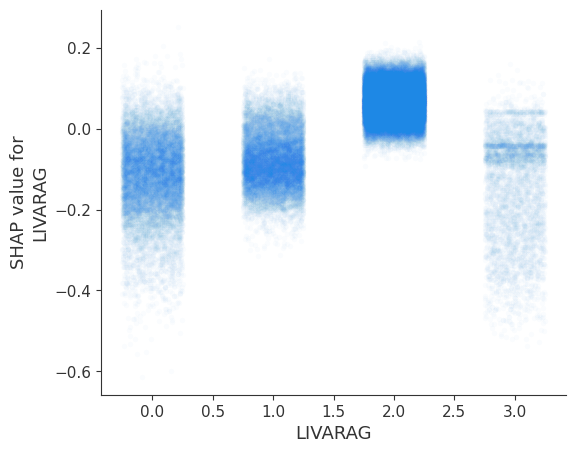

In [49]:
# Show dependence plots for the top n features across all observations
# NOTE: In order to get dependence plot to work, you must revert to matplotlib==3.1.3
# Examples of dependence plots: https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

shap.dependence_plot('LIVARAG', shap_values.values, X_test, x_jitter=0.5, alpha=0.02, interaction_index=None)

In [53]:
shap_importance
# shap_importance.to_csv('shap_importance.csv')

,feature_name,feature_importance,abs_feature_importance
3,SERVICES,1.189940,0.233736
0,STFIPS,0.879635,0.172784
6,PSOURCE,0.302243,0.059369
5,NOPRIOR,0.238238,0.046796
25,FREQ1,0.177404,0.034847
14,DSMCRIT,0.155881,0.030619
31,HLTHINS,0.118238,0.023225
32,PRIMPAY,0.112246,0.022048
33,FREQ_ATND_SELF_HELP,0.109299,0.021469
15,AGE,0.108711,0.021354


# Grouped feature importance

In [51]:
import pandas as pd
g = pd.read_csv('shap_importance_encoded.csv')  #update label and category, then regroup
g

,index,feature_name,feature_label,feature_category,feature_importance,abs_feature_importance
0,3,SERVICES,treatment service,coordination of care,1.204786,0.212295
1,0,STFIPS,state code,geographic,0.516999,0.091100
2,53,REGION,census region,geographic,0.446149,0.078616
3,6,PSOURCE,referral source,coordination of care,0.308769,0.054408
4,52,DIVISION,census division,geographic,0.266251,0.046916
5,5,NOPRIOR,prior treatments,medical history,0.265959,0.046865
6,25,FREQ1,primary frequency,substance use history,0.176536,0.031107
7,31,HLTHINS,health insurance,economic,0.148397,0.026149
8,32,PRIMPAY,dsm diagnosis,medical history,0.140975,0.024841
9,14,DSMCRIT,payment source,economic,0.138571,0.024418


In [107]:
g_grouped = g.groupby('feature_category').sum()['abs_feature_importance'].sort_values(ascending=False)
# g_grouped.to_csv('shap_importance_grouped.csv')
g_grouped

feature_category
coordination of care     0.296157
geographic               0.216632
substance use history    0.189463
medical history          0.124266
economic                 0.101987
personal history         0.035936
demographic              0.035560
Name: abs_feature_importance, dtype: float64

In [108]:
g.sort_values(by='abs_feature_importance', ascending=False)[['feature_label', 'abs_feature_importance']].reset_index(drop=True)

,feature_label,abs_feature_importance
0,treatment service,0.212295
1,state code,0.091100
2,census region,0.078616
3,referral source,0.054408
4,census division,0.046916
5,prior treatments,0.046865
6,primary frequency,0.031107
7,health insurance,0.026149
8,dsm diagnosis,0.024841
9,payment source,0.024418
